# Create the task environment
Need to create an environment in which we can manipulate the frequency of choice in a binary choice task, let's proceed in incremental steps.

## Reward Pairs task

In [1]:
import sys
sys.path.append('..')
from modeling.classes import EnvironmentRewardsPairsTask, AgentQ, AgentCK

from matplotlib import pyplot as plt
import numpy as np
from itertools import combinations

In [2]:
env = EnvironmentRewardsPairsTask(frequency_ratio=5)

## Q-agent simulation

In [35]:
agentQ = AgentQ(alpha=0.1, beta=1)
n_sessions = 100
n_trials = 3000

# initializations
pairs = np.zeros((n_sessions, n_trials, 2), dtype=int)
choices = np.zeros((n_sessions, n_trials), dtype=int)
rewards = np.zeros((n_sessions, n_trials), dtype=int)
q_values = np.zeros((n_sessions, n_trials, 8))

for i in range(n_sessions):
    env.reset()
    agentQ.new_sess()    

    for trial in range(n_trials):
        pair = env.present_stimuli()
        choice = agentQ.get_choice(pair)
        reward = env.get_reward(choice)
        agentQ.update(choice, reward)

        pairs[i, trial] = pair
        choices[i, trial] = choice
        rewards[i, trial] = reward
        q_values[i, trial] = agentQ.q

exp_agentQ = {'pairs': pairs, 'choices': choices, 'rewards': rewards, 'q_values': q_values}

## CK-agent simulation

In [52]:
agentCK = AgentCK(alpha_q=0.1, alpha_h=0.1,
                  beta_q=1, beta_h=1)
n_sessions = 100
n_trials = 3000

# initializations
pairs = np.zeros((n_sessions, n_trials, 2), dtype=int)
choices = np.zeros((n_sessions, n_trials), dtype=int)
rewards = np.zeros((n_sessions, n_trials), dtype=int)
q_values = np.zeros((n_sessions, n_trials, 8))
h_values = np.zeros((n_sessions, n_trials, 8))

for i in range(n_sessions):
    env.reset()
    agentCK.new_sess()    

    for trial in range(n_trials):
        pair = env.present_stimuli()
        choice = agentCK.get_choice(pair)
        reward = env.get_reward(choice)
        agentCK.update(pair, choice, reward)

        pairs[i, trial] = pair
        choices[i, trial] = choice
        rewards[i, trial] = reward
        q_values[i, trial] = agentCK.q
        h_values[i, trial] = agentCK.h

exp_agentCK = {'pairs': pairs, 'choices': choices, 'rewards': rewards, 'q_values': q_values, 'h_values': h_values}

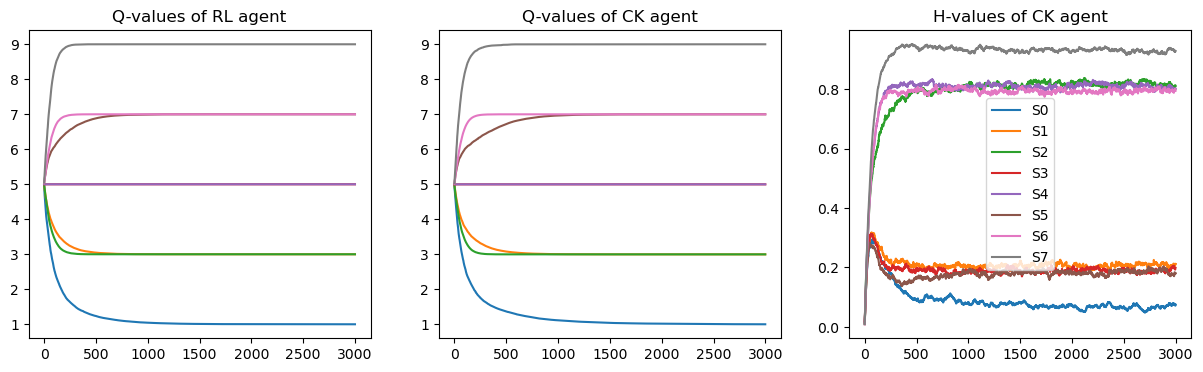

In [53]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].plot(exp_agentQ['q_values'].mean(axis=0))
axs[0].set_title('Q-values of RL agent')
axs[1].plot(exp_agentCK['q_values'].mean(axis=0))
axs[1].set_title('Q-values of CK agent')
axs[2].plot(exp_agentCK['h_values'].mean(axis=0))
axs[2].set_title('H-values of CK agent')
plt.legend(env.stimuli)
plt.show()

## Check the accuracy during training

In [54]:
def compute_accuracy(exp, reward_levels):
    pairs = exp['pairs']
    reward_levels = np.array(reward_levels)
    choices = exp['choices']
    # Get the values for each element in the tuples
    left_reward = reward_levels[pairs[..., 0]]
    right_reward = reward_levels[pairs[..., 1]]
    # Use np.where to choose the element with the higher value
    better_choice = np.where(left_reward >= right_reward, pairs[..., 0], pairs[..., 1])
    correct = choices == better_choice
    return correct

## Q-agent simulation

In [55]:
exp_agentQ.update({'accuracy': compute_accuracy(exp_agentQ, env.rewards)})
exp_agentCK.update({'accuracy': compute_accuracy(exp_agentCK, env.rewards)})

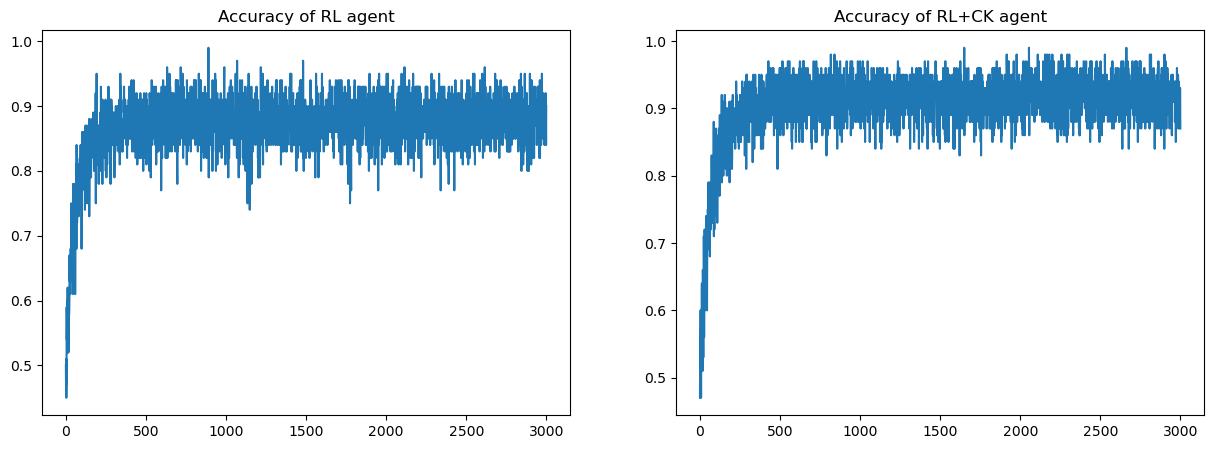

In [56]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].plot(exp_agentQ['accuracy'].mean(axis=0))
axs[0].set_title('Accuracy of RL agent')
axs[1].plot(exp_agentCK['accuracy'].mean(axis=0))
axs[1].set_title('Accuracy of RL+CK agent')
plt.show()

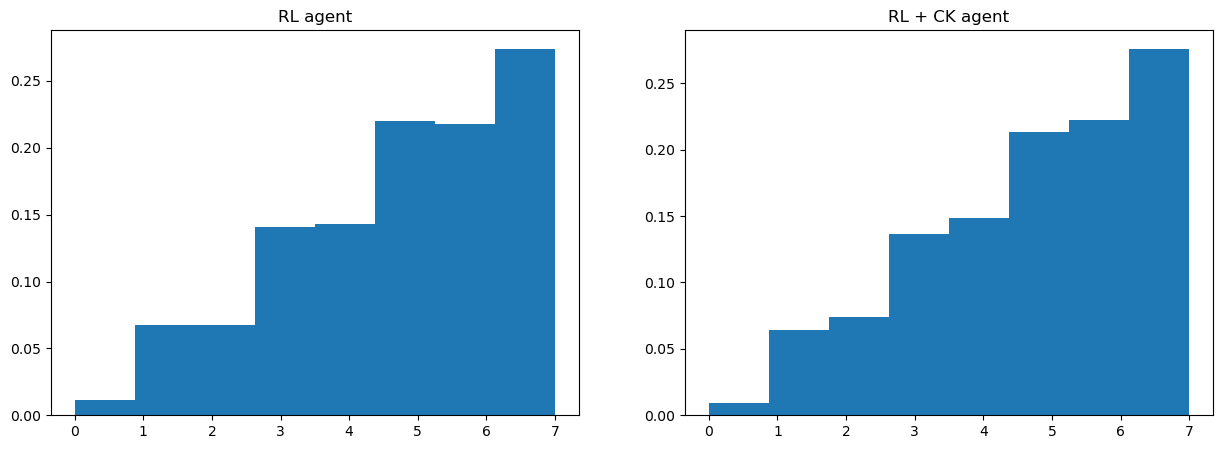

In [58]:
mass_trials = np.repeat(np.array(list(combinations(range(8), 2)), dtype=int), 1000, axis=0)
mass_choices = []

fig, axs = plt.subplots(1,2, figsize=(15,5))

for pair in mass_trials:
    mass_choices.append(agentQ.get_choice(pair))
axs[0].hist(mass_choices, density=True, bins=8)
axs[0].set_title('RL agent')
for pair in mass_trials:
    mass_choices.append(agentCK.get_choice(pair))
axs[1].hist(mass_choices, density=True, bins=8)
axs[1].set_title('RL + CK agent')
plt.show()

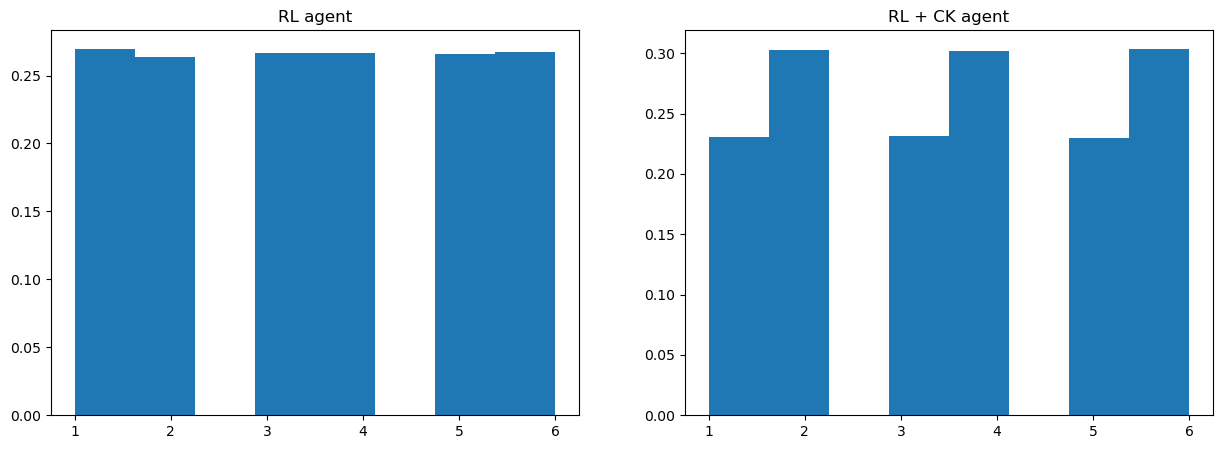

In [59]:
test_trials = np.repeat(np.array([[1,2],[3,4],[5,6]], dtype=int), 10000, axis=0)
test_choices = []

fig, axs = plt.subplots(1,2, figsize=(15,5))

for pair in test_trials:
    test_choices.append(agentQ.get_choice(pair))
axs[0].hist(test_choices, density=True, bins=8)
axs[0].set_title('RL agent')
for pair in test_trials:
    test_choices.append(agentCK.get_choice(pair))
axs[1].hist(test_choices, density=True, bins=8)
axs[1].set_title('RL + CK agent')
plt.show()